In [1]:
import numpy as np
import pandas as pd
import math

## Part 1. Data Preprocessing

In [2]:
df = pd.read_csv('AAPL_max.csv')
df = df.iloc[-math.ceil(len(df) * 0.3):] # only use last 30% of data
df.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
9961,2020-06-16,351.459991,353.200012,344.720001,352.079987,352.079987,41357200.0
9962,2020-06-17,355.149994,355.399994,351.089996,351.589996,351.589996,28532000.0
9963,2020-06-18,351.410004,353.450012,349.220001,351.730011,351.730011,24158600.0


In [3]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

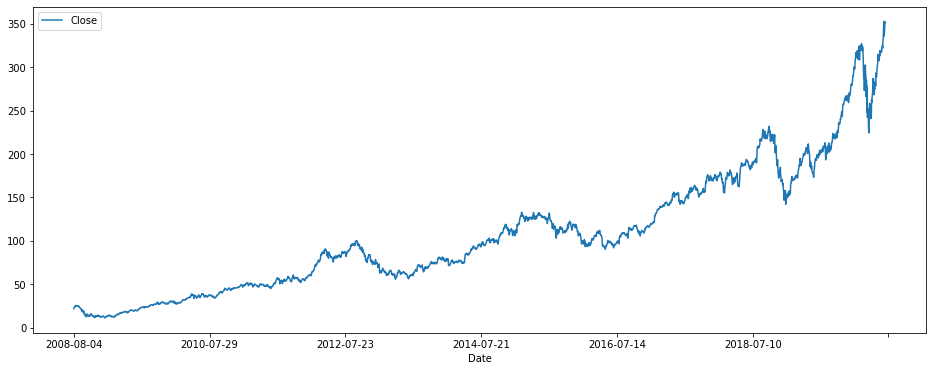

In [4]:
df.plot(x = 'Date', y = 'Close', figsize = (16, 6))

In [5]:
# use Close price for prediction
df = df['Close']

In [6]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
dataset = sc.fit_transform(pd.DataFrame(df).values)

## Part 2. Training

### Function definition for tuning

In [7]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error

def train_pred_eval(dataset,
                    lags = 7, 
                    test_size = 0.25,
                    lstm_layers = 0,
                    lstm_units = 50,
                    dropout_prob = 0.2, 
                    optimizer = 'adam', 
                    batch_size = 32,
                    epochs = 10):    
    # use lags of data as features
    x, y = [], []
    for i in range(lags, len(dataset)):
        x.append(dataset[i-lags:i])
        y.append(dataset[i])
    x, y = np.array(x), np.array(y)

    # split
    train_size = len(x) - math.floor(len(x) * test_size)
    x_train, y_train = x[:train_size], y[:train_size]
    x_test, y_test = x[train_size:], y[train_size:]

    # reshape to add one dimension as lstm_1_input expects
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # init
    rnn = Sequential()

    # 1st LSTM layer
    rnn.add(LSTM(units = lstm_units, return_sequences = True, input_shape = (x_train.shape[1], 1)))
    rnn.add(Dropout(dropout_prob))

    for _ in range(0, lstm_layers):
        rnn.add(LSTM(units = lstm_units, return_sequences = True))
        rnn.add(Dropout(dropout_prob))

    # last LSTM layer
    rnn.add(LSTM(units = lstm_units))
    rnn.add(Dropout(dropout_prob))

    # output layer
    rnn.add(Dense(units = 1))

    # compile
    rnn.compile(optimizer = optimizer, loss = 'mean_squared_error')
    
    # predict
    rnn.fit(x_train, y_train, batch_size = batch_size, epochs = epochs)
    
    # predict
    y_pred = rnn.predict(x_test)
    y_pred = sc.inverse_transform(y_pred)
    y_test = sc.inverse_transform(y_test)
    
    # eval
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [8]:
import time
from tqdm.notebook import tqdm

error_rate = {'param': [], 'rmse': []}
params = [100, 90, 80, 70, 60, 50]

# train, predict and evaluate
start_ts = time.time()
for param in tqdm(params):
    rmse = train_pred_eval(dataset,
                           lags = 3,                 
                           test_size = 0.2,
                           lstm_layers = 0,
                           lstm_units = 128,
                           dropout_prob = 1, 
                           optimizer = 'nadam', 
                           batch_size = 8,
                           epochs = param)
    error_rate['param'].append(param)
    error_rate['rmse'].append(rmse)
    
end_ts = time.time()
print(f'time elapsed: {(end_ts - start_ts)/60.0} mins')


Epoch 1/100
2390/2390 [==============================] - 7s 3ms/step - loss: 0.0082
Epoch 2/100
2390/2390 [==============================] - 5s 2ms/step - loss: 0.0022
Epoch 3/100
2390/2390 [==============================] - 5s 2ms/step - loss: 0.0016
Epoch 4/100
2390/2390 [==============================] - 5s 2ms/step - loss: 0.0014
Epoch 5/100
2390/2390 [==============================] - 5s 2ms/step - loss: 0.0011
Epoch 6/100
2390/2390 [==============================] - 5s 2ms/step - loss: 0.0012
Epoch 7/100
2390/2390 [==============================] - 5s 2ms/step - loss: 0.0015
Epoch 8/100
2390/2390 [==============================] - 5s 2ms/step - loss: 8.4170e-04
Epoch 9/100
2390/2390 [==============================] - 5s 2ms/step - loss: 9.1768e-04
Epoch 10/100
2390/2390 [==============================] - 5s 2ms/step - loss: 8.6658e-04
Epoch 11/100
2390/2390 [==============================] - 5s 2ms/step - loss: 8.1605e-04
Epoch 12/100
2390/2390 [==============================] -

2390/2390 [==============================] - 6s 2ms/step - loss: 4.0371e-04
Epoch 85/90
2390/2390 [==============================] - 6s 3ms/step - loss: 4.0820e-04
Epoch 86/90
2390/2390 [==============================] - 6s 2ms/step - loss: 4.3753e-04
Epoch 87/90
2390/2390 [==============================] - 6s 2ms/step - loss: 4.1895e-04
Epoch 88/90
2390/2390 [==============================] - 6s 2ms/step - loss: 4.2187e-04
Epoch 89/90
2390/2390 [==============================] - 6s 2ms/step - loss: 4.0820e-04
Epoch 90/90
2390/2390 [==============================] - 6s 2ms/step - loss: 4.2534e-04
Epoch 1/80
2390/2390 [==============================] - 7s 3ms/step - loss: 0.0099
Epoch 2/80
2390/2390 [==============================] - 6s 2ms/step - loss: 0.0022
Epoch 3/80
2390/2390 [==============================] - 6s 2ms/step - loss: 0.0019
Epoch 4/80
2390/2390 [==============================] - 6s 2ms/step - loss: 9.7441e-04
Epoch 5/80
2390/2390 [==============================] - 6s 2

2390/2390 [==============================] - 6s 3ms/step - loss: 0.0011
Epoch 9/70
2390/2390 [==============================] - 6s 3ms/step - loss: 9.1482e-04
Epoch 10/70
2390/2390 [==============================] - 6s 3ms/step - loss: 9.9025e-04
Epoch 11/70
2390/2390 [==============================] - 6s 3ms/step - loss: 8.9801e-04
Epoch 12/70
2390/2390 [==============================] - 6s 3ms/step - loss: 7.5901e-04
Epoch 13/70
2390/2390 [==============================] - 6s 3ms/step - loss: 6.7381e-04
Epoch 14/70
2390/2390 [==============================] - 6s 3ms/step - loss: 6.7962e-04
Epoch 15/70
2390/2390 [==============================] - 6s 3ms/step - loss: 6.5436e-04
Epoch 16/70
2390/2390 [==============================] - 6s 2ms/step - loss: 5.5261e-04
Epoch 17/70
2390/2390 [==============================] - 6s 3ms/step - loss: 5.3992e-04
Epoch 18/70
2390/2390 [==============================] - 6s 3ms/step - loss: 5.4569e-04
Epoch 19/70
2390/2390 [==========================

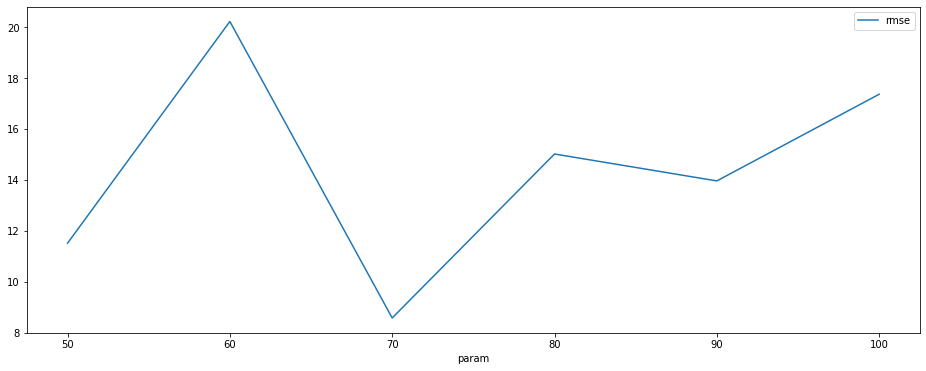

In [9]:
error_rate_df = pd.DataFrame(error_rate)
error_rate_df.plot(x = 'param', y = 'rmse', figsize = (16, 6))

In [11]:
error_rate_df

,param,rmse
0,100,17.360848
1,90,13.958408
2,80,15.014908
3,70,8.577640
4,60,20.218084
5,50,11.512615
